In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tools import *
import operator
import itertools


In [2]:
train_data=torchvision.datasets.MNIST('./', train=True, download=True,transform=torchvision.transforms.ToTensor())
test_data=torchvision.datasets.MNIST('./', train=False, download=True,transform=torchvision.transforms.ToTensor())
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True)

In [3]:
train_dict={}
for (data, target) in train_data:
    if  target not in train_dict:
        train_dict[ target]=[]
        train_dict[ target].append(data)
    else:
        train_dict[ target].append(data)

In [4]:
initial_train_data=[]
initial_train_label=[]
for i in range(7):
    for j in range(0,10):
        initial_train_data.append(train_dict[i][j])
        initial_train_label.append(i)
    
print(initial_train_label)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


In [5]:
initial_train_data_tensor=torch.stack(initial_train_data)
initial_train_label_tensor=torch.tensor(initial_train_label)
train_x=torch.stack([data for (data, target) in train_data])
train_label=torch.tensor([target for (data, target) in train_data])
print(initial_train_data_tensor.size())
print(initial_train_label_tensor.size())

torch.Size([70, 1, 28, 28])
torch.Size([70])


In [975]:
class Net(nn.Module):
    def __init__(self,feature_dim,q_rank):
        super(Net, self).__init__()
        self.feature_dim=feature_dim
        self.last_weight_dim=feature_dim*10
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 100)
        self.fc2 = nn.Linear(100, feature_dim)

        self.q_rank=q_rank
        self.prior_mu=torch.tensor(np.zeros(self.last_weight_dim), dtype=torch.float, requires_grad=False)
        self.prior_sigma=torch.tensor(1.0, requires_grad=False)
        
        self.q_mu=(torch.randn(self.last_weight_dim)*0.1).requires_grad_()
        self.q_sigma=torch.tensor(1.0, requires_grad=True)
        self.q_L=(torch.randn(self.last_weight_dim,q_rank)*0.1).requires_grad_()
        
        
        params = list(self.parameters()) + [self.q_mu,self.q_L,self.q_sigma]
        self.optimizer = optim.Adam(params, lr=0.001)
        self.feature_optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.final_optimizer = optim.Adam([ self.q_mu,self.q_L,self.q_sigma], lr=0.001)

    def forward(self, x, final_weight):
        x=x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x =torch.tanh(self.fc2(x))
        x= torch.matmul(x,final_weight)
        return F.log_softmax(x,dim=-1)
    
    
    def feature_forward(self, x ):
        x=x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = torch.tanh( self.fc2(x))
        return x
    
    def predict(self,x):
        with torch.no_grad():
            eps=torch.tensor(np.random.normal([self.last_weight_dim]),dtype=torch.float)
            final_weight_sample= (self.q_mu+eps*torch.sqrt(self.q_diag)).view(self.feature_dim,10)
            output = torch.exp(self.forward(x,final_weight_sample))
            pred = output.data.max(dim=1, keepdim=True)[1]
            return pred
        
    def test_prediction(self, x):
        with torch.no_grad():
            final_weight_mean=self.q_mu.view(self.feature_dim,10)
            output = torch.exp(self.forward(x,final_weight_mean))
            pred = output.data.max(dim=1, keepdim=True)[1]
            return pred
        
        
    def predictive_distribution_entropy(self,x):
        with torch.no_grad():
            final_weight_samples=low_rank_gaussian_sample(self.q_mu,self.q_L,self.q_sigma,sample_num).view(sample_num,self.feature_dim,10).permute(0, 2, 1)
            feature_of_data=self.feature_forward(x)[0]
            output_logit=final_weight_samples@feature_of_data
            output_dis=torch.distributions.categorical.Categorical(logits=output_logit)


            sample=output_dis.sample([100]).reshape([-1,1])
            entropy=-torch.mean(torch.log(torch.mean(torch.exp(output_dis.log_prob(sample)),dim=-1)))
        return entropy
    
    
    def likelihood_eva(self,x,label, sample_num=100, if_online=False):
        with torch.no_grad():
            eps=torch.randn([sample_num,self.last_weight_dim])
            final_weight_samples=low_rank_gaussian_sample(self.q_mu,self.q_L,self.q_sigma,sample_num).view(sample_num,self.feature_dim,10).permute(0, 2, 1)
            feature_of_data=self.feature_forward(x)
            output=torch.mean(F.log_softmax((final_weight_samples@feature_of_data.t()).permute(0, 2, 1),dim=-1),0)
            predicted=output.data.max(dim=1, keepdim=True)[1].view(-1)
            accuracy=(predicted == label).sum().item()/label.size(0)
            nll_loss= F.nll_loss(output,label,reduction='sum')
            if if_online:
                curr_prior_mu = self.q_mu.clone().detach()
                curr_prior_L = self.q_L.clone().detach()
                curr_prior_sigma = self.q_sigma.clone().detach()
                kl=KL_low_rank_gaussian_with_low_rank_gaussian(self.q_mu,self.q_L,self.q_sigma,curr_prior_mu,curr_prior_L,curr_prior_sigma)
            else:
                kl=KL_low_rank_gaussian_with_diag_gaussian(self.q_mu,self.q_L,self.q_sigma,self.prior_mu,self.prior_sigma)
            neg_elbo=kl+nll_loss
        
        return -neg_elbo,accuracy
    
    
    
    def predictive_distribution_entropy_2(self,x, sample_num=100):
        with torch.no_grad():
            final_weight_samples=low_rank_gaussian_sample(self.q_mu,self.q_L,self.q_sigma,sample_num).view(sample_num,self.feature_dim,10).permute(0, 2, 1)
            feature_of_data=self.feature_forward(x)[0]
            output_logit=final_weight_samples@feature_of_data
            output_dis=torch.distributions.categorical.Categorical(logits=output_logit)

            final_weight_samples=low_rank_gaussian_sample(self.q_mu,self.q_L,self.q_sigma,sample_num).view(sample_num,self.feature_dim,10).permute(0, 2, 1)
            feature_of_data=self.feature_forward(x)[0]
            output_logit=final_weight_samples@feature_of_data
            output_dis_for_sample=torch.distributions.categorical.Categorical(logits=output_logit)

            sample=output_dis_for_sample.sample([sample_num]).reshape([-1,1])
            entropy=-torch.mean(torch.log(torch.mean(torch.exp(output_dis.log_prob(sample)),dim=-1)))
        return entropy
    
    
#       def lower_bound_entropy(self,x):
#         eps=torch.tensor(np.random.normal(size=[100,200]),dtype=torch.float)
#         final_weight_samples=(torch.sqrt(self.q_diag).repeat(100).view(100,200)*eps+self.q_mu).view(100,20,10).permute(0, 2, 1)
#         feature_of_data=self.feature_forward(x)[0]
#         output_logit=final_weight_samples@feature_of_data
#         output_dis=torch.distributions.categorical.Categorical(logits=output_logit)
#         sample=output_dis.sample([100]).reshape([-1,1])
        
#         eps=torch.tensor(np.random.normal(size=[100,200]),dtype=torch.float)
#         final_weight_samples=(torch.sqrt(self.q_diag).repeat(100).view(100,200)*eps+self.q_mu).view(100,20,10).permute(0, 2, 1)
        
        
        
        
        
        entropy=-torch.mean(torch.log(torch.mean(torch.exp(output_dis.log_prob(sample)),dim=-1)))
        return entropy
    
    
    def online_train(self,x,label,sample_num=1):
        train_losses = []
        total_size=x.size(0)
        curr_prior_mu = self.q_mu.clone().detach()
        curr_prior_L = self.q_L.clone().detach()
        curr_prior_sigma = self.q_sigma.clone().detach()
        correct_flag=0
        
#         self.q_mu=(torch.randn(self.last_weight_dim)*0.1).requires_grad_()
#         self.q_sigma=torch.tensor(1.0, requires_grad=True)
#         self.q_L=(torch.randn(self.last_weight_dim,self.q_rank)*0.1).requires_grad_()
        with torch.no_grad():
            feature_of_data_o=self.feature_forward(x)
#         print(feature_of_data.size())
        feature_of_data=feature_of_data_o.clone().detach()
#         while correct_flag<5:
        right=0
        right_list=[]
        for i in range(0,50000):
            self.final_optimizer.zero_grad()
            final_weight_samples=low_rank_gaussian_sample(self.q_mu,self.q_L,self.q_sigma,sample_num).view(sample_num,self.feature_dim,10).permute(0, 2, 1)
#             final_weight_sample= low_rank_gaussian_one_sample(self.q_mu,self.q_L,self.q_sigma).view(self.feature_dim,10)
            output =F.log_softmax((final_weight_samples@feature_of_data.t()).permute(0,2,1),dim=-1).view(sample_num,10)
            label_batch=label.repeat(sample_num)
            nll_loss= F.nll_loss(output,label_batch,reduction='mean')
            kl=KL_low_rank_gaussian_with_low_rank_gaussian(self.q_mu,self.q_L,self.q_sigma,curr_prior_mu,curr_prior_L,curr_prior_sigma)
            neg_elbo=kl+2*nll_loss
            neg_elbo.backward()
            self.final_optimizer.step()
            train_losses.append(neg_elbo.item())
            if output.data.max(dim=1, keepdim=True)[1][0].item()==label.item():
                right+=1
                
            if i%100==0:
                print('accuracy:', right/100)
                right_list.append(right/100)
                right=0
                
            
#             if output.data.max(dim=1, keepdim=True)[1].item()==label.item():
#                 correct_flag+=1
#             else:
#                 correct_flag=0
        plt.plot(right_list)
        plt.show()
        plt.plot(train_losses)
        plt.show()
        
        
    
    def pre_train(self,x,label):
        train_losses = []
        batch_size=50
        for epoch in range(0,1000):
            for it in range(0,int(x.size(0)/batch_size)+1):
                index=np.random.choice(x.size(0),batch_size)
                self.optimizer.zero_grad()
                final_weight_sample= low_rank_gaussian_one_sample(self.q_mu,self.q_L,self.q_sigma).view(self.feature_dim,10)
                output = self.forward(x[index],final_weight_sample)
                nll_loss= F.nll_loss(output,label[index],reduction='sum')*(float(x.size(0))/float(batch_size))
                kl=KL_low_rank_gaussian_with_diag_gaussian(self.q_mu,self.q_L,self.q_sigma,self.prior_mu,self.prior_sigma)
                neg_elbo=kl+nll_loss
                neg_elbo.backward()
                self.optimizer.step()
                train_losses.append(neg_elbo.item())
        plt.plot(train_losses)
        plt.show()
        return train_losses
        
    def test(self):
        correct=0
        for data, target in test_loader:
            pred = self.predict(data)
            correct += pred.eq(target.data.view_as(pred)).sum()
            correct_ratio= float(correct)/len(test_loader.dataset)
        return correct_ratio
    

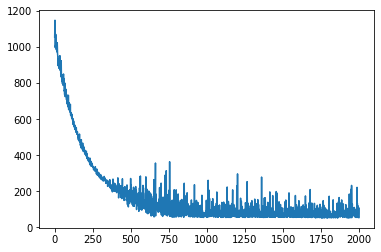

In [982]:
active_bnn_1 = Net(feature_dim=200,q_rank=100)
nelbo_1=active_bnn_1.pre_train(initial_train_data_tensor,initial_train_label_tensor)

In [845]:
likelihood_of_initial_dataset,accuracy=active_bnn_1.likelihood_eva(initial_train_data_tensor,initial_train_label_tensor)
print(likelihood_of_initial_dataset)
print(accuracy)

tensor([[-55.8837]])
1.0


In [853]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

tensor(1.0579)
tensor(1.1921)
tensor(1.7665)
tensor(0.8220)
tensor(0.7214)
tensor(0.8168)
tensor(0.6236)
tensor(0.8972)
tensor(0.6421)


In [983]:
# active_bnn_1 = Net(feature_dim=200,q_rank=100)
for i in range(0,1):
    x_new=train_dict[8][20].view(-1,1,28,28)
    label_new=torch.tensor([8])
    active_bnn_1.online_train(x_new,label_new)
    print('entropy',active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
    likelihood_of_initial_dataset,accuracy=active_bnn_1.likelihood_eva(initial_train_data_tensor,initial_train_label_tensor)
    print('lieklihood',likelihood_of_initial_dataset)
    print('accuracy',accuracy)

accuracy: 0.0
accuracy: 0.18
accuracy: 0.23
accuracy: 0.27
accuracy: 0.22
accuracy: 0.21
accuracy: 0.27
accuracy: 0.26
accuracy: 0.21
accuracy: 0.26
accuracy: 0.19
accuracy: 0.25
accuracy: 0.29
accuracy: 0.22
accuracy: 0.32
accuracy: 0.33
accuracy: 0.28
accuracy: 0.28
accuracy: 0.33
accuracy: 0.27
accuracy: 0.33
accuracy: 0.27
accuracy: 0.28
accuracy: 0.22
accuracy: 0.36
accuracy: 0.34
accuracy: 0.26
accuracy: 0.22
accuracy: 0.27


KeyboardInterrupt: 

0.999


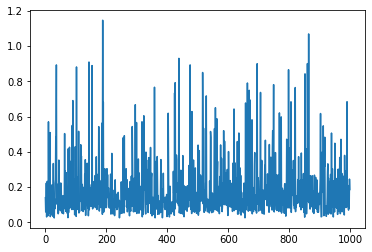

entropy tensor(1.7738)
lieklihood tensor([[-150.6835]])
accuracy 0.8571428571428571
0.999


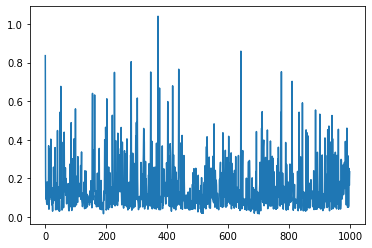

entropy tensor(1.8166)
lieklihood tensor([[-162.5630]])
accuracy 0.8571428571428571
1.0


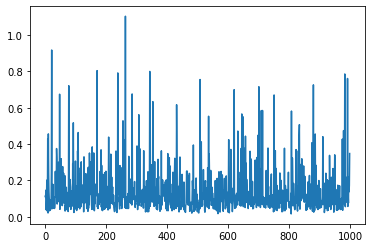

entropy tensor(1.8441)
lieklihood tensor([[-162.6620]])
accuracy 0.8571428571428571
1.0


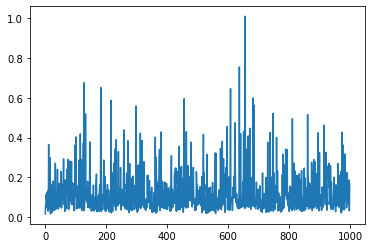

entropy tensor(1.8330)
lieklihood tensor([[-161.8409]])
accuracy 0.8571428571428571
0.998


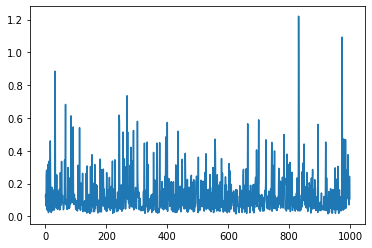

entropy tensor(1.8528)
lieklihood tensor([[-169.0583]])
accuracy 0.8571428571428571
0.998


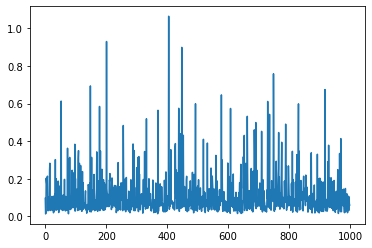

entropy tensor(1.8556)
lieklihood tensor([[-183.6871]])
accuracy 0.8571428571428571
1.0


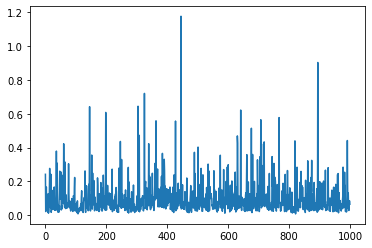

entropy tensor(1.8154)
lieklihood tensor([[-183.8927]])
accuracy 0.8571428571428571
0.999


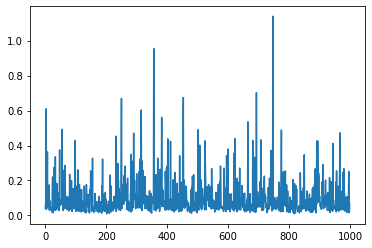

entropy tensor(1.8086)
lieklihood tensor([[-185.2292]])
accuracy 0.8571428571428571
1.0


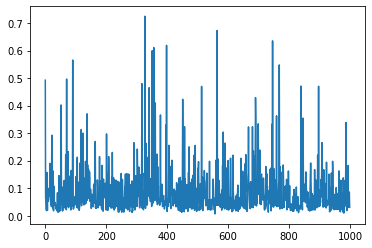

entropy tensor(1.7405)
lieklihood tensor([[-189.4835]])
accuracy 0.8571428571428571
1.0


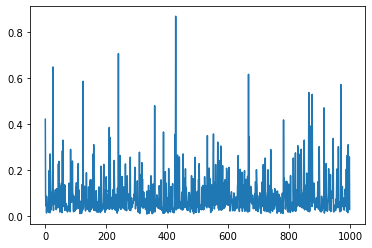

entropy tensor(1.8710)
lieklihood tensor([[-186.7575]])
accuracy 0.8571428571428571


In [800]:
for i in range(0,10):
    x_new=train_dict[8][21].view(-1,1,28,28)
    label_new=torch.tensor([8])
    active_bnn_1.online_train(x_new,label_new)
    print('entropy',active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
    likelihood_of_initial_dataset,accuracy=active_bnn_1.likelihood_eva(initial_train_data_tensor,initial_train_label_tensor)
    print('lieklihood',likelihood_of_initial_dataset)
    print('accuracy',accuracy)

In [799]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

tensor(0.6840)
tensor(1.8111)
tensor(0.6825)
tensor(0.1533)
tensor(0.1004)
tensor(0.3481)
tensor(0.4446)
tensor(1.2513)
tensor(0.5577)


4


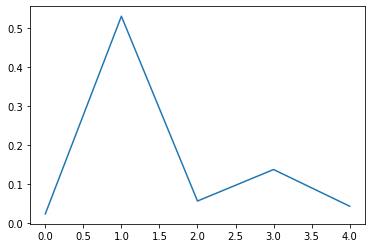

In [772]:
x_new=train_dict[4][16].view(-1,1,28,28)
label_new=torch.tensor([4])
active_bnn_1.online_train(x_new,label_new)

In [773]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

tensor(0.6466)
tensor(0.4062)
tensor(0.5515)
tensor(0.8226)
tensor(0.6948)
tensor(0.2979)
tensor(0.4668)
tensor(0.5112)
tensor(0.3625)


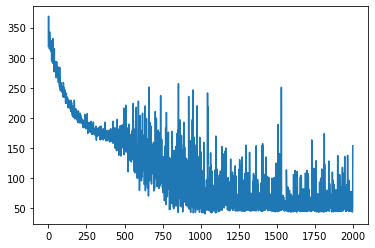

In [652]:
active_bnn_1 = Net(feature_dim=50,q_rank=100)
nelbo_1=active_bnn_1.pre_train(initial_train_data_tensor,initial_train_label_tensor)

4


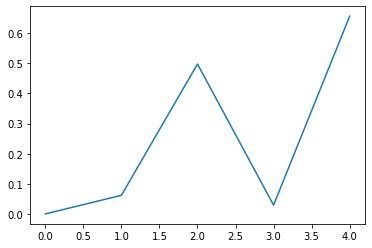

In [653]:
x_new=train_dict[4][16].view(-1,1,28,28)
label_new=torch.tensor([4])

active_bnn_1.online_train(x_new,label_new)

In [654]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

torch.Size([100, 10])
torch.Size([10000, 1])
tensor(0.5603, grad_fn=<NegBackward>)
torch.Size([100, 10])
torch.Size([10000, 1])
tensor(1.6844, grad_fn=<NegBackward>)
torch.Size([100, 10])
torch.Size([10000, 1])
tensor(1.4153, grad_fn=<NegBackward>)
torch.Size([100, 10])
torch.Size([10000, 1])
tensor(0.6539, grad_fn=<NegBackward>)
torch.Size([100, 10])
torch.Size([10000, 1])
tensor(0.6079, grad_fn=<NegBackward>)
torch.Size([100, 10])
torch.Size([10000, 1])
tensor(0.4694, grad_fn=<NegBackward>)
torch.Size([100, 10])
torch.Size([10000, 1])
tensor(0.3236, grad_fn=<NegBackward>)
torch.Size([100, 10])
torch.Size([10000, 1])
tensor(0.5761, grad_fn=<NegBackward>)
torch.Size([100, 10])
torch.Size([10000, 1])
tensor(0.4231, grad_fn=<NegBackward>)


In [655]:
x_new=train_dict[8][20].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_1.online_train(x_new,label_new)

KeyboardInterrupt: 

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

1


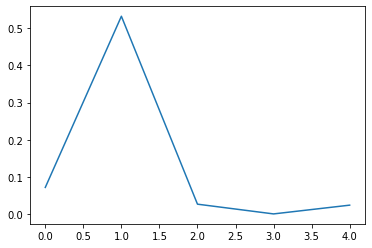

In [327]:
x_new=train_dict[1][20].view(-1,1,28,28)
label_new=torch.tensor([1])

active_bnn_1.online_train(x_new,label_new)

In [342]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

tensor(0.3996, grad_fn=<NegBackward>)
tensor(1.6959, grad_fn=<NegBackward>)
tensor(0.9995, grad_fn=<NegBackward>)
tensor(0.8358, grad_fn=<NegBackward>)
tensor(0.7439, grad_fn=<NegBackward>)
tensor(0.1764, grad_fn=<NegBackward>)
tensor(0.2526, grad_fn=<NegBackward>)
tensor(0.7427, grad_fn=<NegBackward>)
tensor(0.2616, grad_fn=<NegBackward>)


8


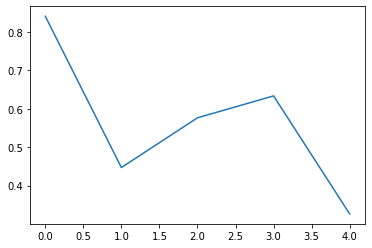

In [355]:
x_new=train_dict[8][20].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_1.online_train(x_new,label_new)

4


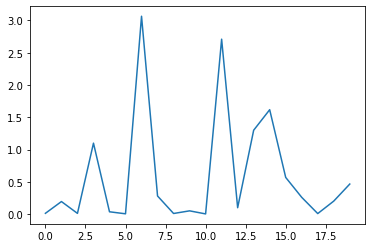

In [144]:
x_new=train_dict[4][16].view(-1,1,28,28)
label_new=torch.tensor([4])

active_bnn_1.online_train(x_new,label_new)

In [362]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][22]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][23]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

tensor(0.4386, grad_fn=<NegBackward>)
tensor(1.7288, grad_fn=<NegBackward>)
tensor(0.8570, grad_fn=<NegBackward>)
tensor(0.9976, grad_fn=<NegBackward>)
tensor(2.0370, grad_fn=<NegBackward>)
tensor(0.7564, grad_fn=<NegBackward>)
tensor(0.7150, grad_fn=<NegBackward>)
tensor(0.0592, grad_fn=<NegBackward>)
tensor(0.2137, grad_fn=<NegBackward>)
tensor(0.9262, grad_fn=<NegBackward>)
tensor(0.2492, grad_fn=<NegBackward>)


8


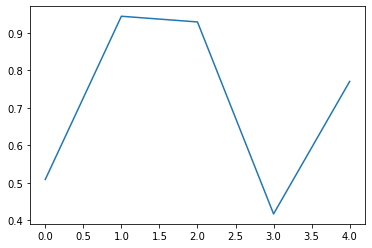

In [371]:
x_new=train_dict[8][20].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_1.online_train(x_new,label_new)

In [372]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][22]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][23]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

tensor(0.3006, grad_fn=<NegBackward>)
tensor(1.7008, grad_fn=<NegBackward>)
tensor(0.8001, grad_fn=<NegBackward>)
tensor(0.8395, grad_fn=<NegBackward>)
tensor(1.9983, grad_fn=<NegBackward>)
tensor(0.8291, grad_fn=<NegBackward>)
tensor(0.8093, grad_fn=<NegBackward>)
tensor(0.1546, grad_fn=<NegBackward>)
tensor(0.3277, grad_fn=<NegBackward>)
tensor(0.7980, grad_fn=<NegBackward>)
tensor(0.1456, grad_fn=<NegBackward>)


8


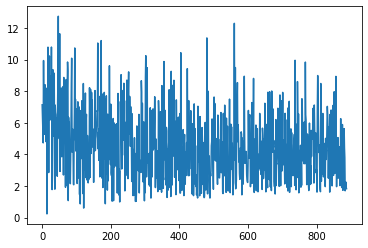

In [616]:
x_new=train_dict[8][20].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_2.online_train(x_new,label_new)

In [617]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][22]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][23]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

tensor(0.9142, grad_fn=<NegBackward>)
tensor(1.0878, grad_fn=<NegBackward>)
tensor(1.0933, grad_fn=<NegBackward>)
tensor(2.0300, grad_fn=<NegBackward>)
tensor(1.6463, grad_fn=<NegBackward>)
tensor(0.6693, grad_fn=<NegBackward>)
tensor(0.6083, grad_fn=<NegBackward>)
tensor(0.3806, grad_fn=<NegBackward>)
tensor(0.3826, grad_fn=<NegBackward>)
tensor(1.6771, grad_fn=<NegBackward>)
tensor(0.3788, grad_fn=<NegBackward>)


8


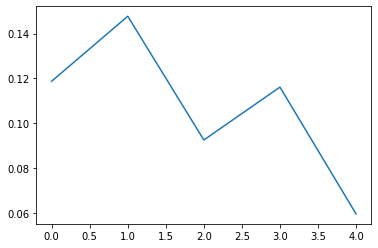

In [630]:
x_new=train_dict[8][22].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_2.online_train(x_new,label_new)

In [632]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][22]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][23]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

tensor(0.9162, grad_fn=<NegBackward>)
tensor(1.1567, grad_fn=<NegBackward>)
tensor(1.0733, grad_fn=<NegBackward>)
tensor(2.0003, grad_fn=<NegBackward>)
tensor(1.6221, grad_fn=<NegBackward>)
tensor(0.4295, grad_fn=<NegBackward>)
tensor(0.6027, grad_fn=<NegBackward>)
tensor(0.4780, grad_fn=<NegBackward>)
tensor(0.4077, grad_fn=<NegBackward>)
tensor(1.6063, grad_fn=<NegBackward>)
tensor(0.5943, grad_fn=<NegBackward>)


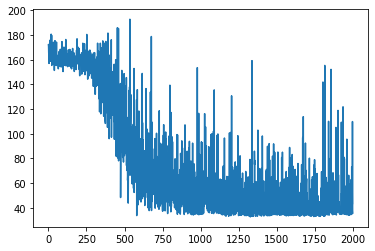

In [614]:
active_bnn_2 = Net(q_rank=2)
nelbo_2=active_bnn_2.pre_train(initial_train_data_tensor,initial_train_label_tensor)

In [615]:
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[8][22]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[8][23]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[4][15]))

tensor(0.4414, grad_fn=<NegBackward>)
tensor(0.9137, grad_fn=<NegBackward>)
tensor(1.3324, grad_fn=<NegBackward>)
tensor(1.7000, grad_fn=<NegBackward>)
tensor(1.5720, grad_fn=<NegBackward>)
tensor(0.4126, grad_fn=<NegBackward>)
tensor(0.5346, grad_fn=<NegBackward>)
tensor(0.4359, grad_fn=<NegBackward>)
tensor(0.4016, grad_fn=<NegBackward>)
tensor(0.7585, grad_fn=<NegBackward>)
tensor(0.4193, grad_fn=<NegBackward>)


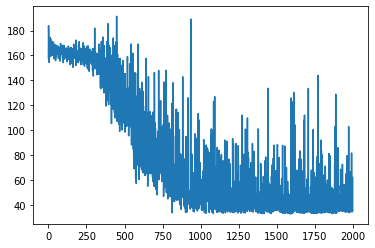

In [11]:
active_bnn_3 = Net(q_rank=3)
nelbo_3=active_bnn_3.pre_train(initial_train_data_tensor,initial_train_label_tensor)

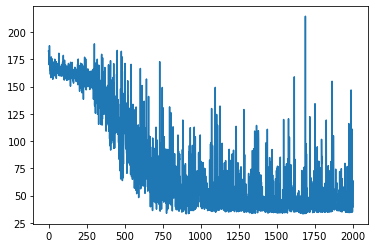

In [373]:
active_bnn_10 = Net(q_rank=10)
nelbo_10=active_bnn_10.pre_train(initial_train_data_tensor,initial_train_label_tensor)

In [374]:
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][22]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][23]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[4][15]))

tensor(0.5596, grad_fn=<NegBackward>)
tensor(1.5693, grad_fn=<NegBackward>)
tensor(1.3465, grad_fn=<NegBackward>)
tensor(0.5687, grad_fn=<NegBackward>)
tensor(1.6367, grad_fn=<NegBackward>)
tensor(0.4393, grad_fn=<NegBackward>)
tensor(0.5522, grad_fn=<NegBackward>)
tensor(0.7101, grad_fn=<NegBackward>)
tensor(0.4363, grad_fn=<NegBackward>)
tensor(0.5237, grad_fn=<NegBackward>)
tensor(0.4602, grad_fn=<NegBackward>)


8


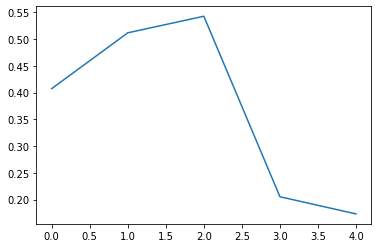

In [425]:
x_new=train_dict[8][20].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_10.online_train(x_new,label_new)

In [426]:
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][22]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][23]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[4][15]))

tensor(0.8863, grad_fn=<NegBackward>)
tensor(1.1762, grad_fn=<NegBackward>)
tensor(1.5940, grad_fn=<NegBackward>)
tensor(0.9402, grad_fn=<NegBackward>)
tensor(1.6638, grad_fn=<NegBackward>)
tensor(0.5172, grad_fn=<NegBackward>)
tensor(0.8894, grad_fn=<NegBackward>)
tensor(0.4103, grad_fn=<NegBackward>)
tensor(0.2322, grad_fn=<NegBackward>)
tensor(0.7796, grad_fn=<NegBackward>)
tensor(0.3673, grad_fn=<NegBackward>)


8


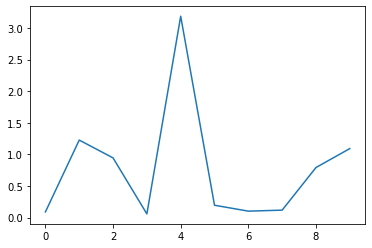

In [464]:
x_new=train_dict[8][21].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_10.online_train(x_new,label_new)

In [465]:
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][22]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][23]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[4][15]))

tensor(0.5901, grad_fn=<NegBackward>)
tensor(0.6995, grad_fn=<NegBackward>)
tensor(1.2192, grad_fn=<NegBackward>)
tensor(1.0269, grad_fn=<NegBackward>)
tensor(1.7690, grad_fn=<NegBackward>)
tensor(0.8126, grad_fn=<NegBackward>)
tensor(0.8359, grad_fn=<NegBackward>)
tensor(0.3976, grad_fn=<NegBackward>)
tensor(0.4226, grad_fn=<NegBackward>)
tensor(0.7254, grad_fn=<NegBackward>)
tensor(0.3370, grad_fn=<NegBackward>)


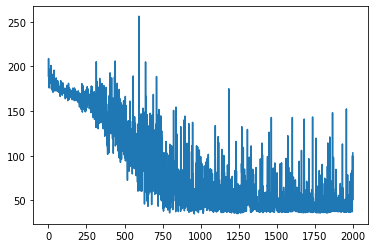

In [13]:
active_bnn_50 = Net(q_rank=50)
nelbo_50=active_bnn_50.pre_train(initial_train_data_tensor,initial_train_label_tensor)

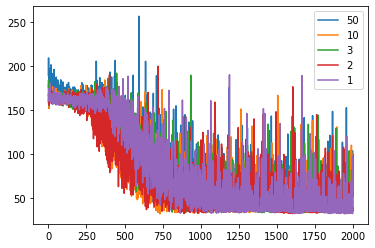

In [49]:
plt.plot(nelbo_50,label='50')
plt.plot(nelbo_10,label='10')
plt.plot(nelbo_3,label='3')
plt.plot(nelbo_2,label='2')
plt.plot(nelbo_1,label='1')

plt.legend()
plt.show()

In [54]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

tensor(0.4663, grad_fn=<NegBackward>)
tensor(0.6689, grad_fn=<NegBackward>)
tensor(1.3006, grad_fn=<NegBackward>)
tensor(0.4201, grad_fn=<NegBackward>)
tensor(0.3474, grad_fn=<NegBackward>)
tensor(0.3395, grad_fn=<NegBackward>)
tensor(0.3347, grad_fn=<NegBackward>)
tensor(1.1697, grad_fn=<NegBackward>)
tensor(0.4601, grad_fn=<NegBackward>)


In [55]:
cccccccccccccccccccc

KeyboardInterrupt: 

In [23]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

tensor(0.5498, grad_fn=<NegBackward>)
tensor(1.6703, grad_fn=<NegBackward>)
tensor(1.3073, grad_fn=<NegBackward>)
tensor(0.4808, grad_fn=<NegBackward>)
tensor(0.4381, grad_fn=<NegBackward>)
tensor(0.3719, grad_fn=<NegBackward>)
tensor(0.5106, grad_fn=<NegBackward>)
tensor(1.3021, grad_fn=<NegBackward>)
tensor(0.6422, grad_fn=<NegBackward>)


8


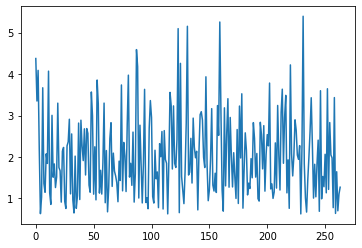

In [26]:
x_new=train_dict[8][20].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_1.online_train(x_new,label_new)

In [28]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

tensor(0.4383, grad_fn=<NegBackward>)
tensor(1.8073, grad_fn=<NegBackward>)
tensor(1.1011, grad_fn=<NegBackward>)
tensor(0.3264, grad_fn=<NegBackward>)
tensor(0.5321, grad_fn=<NegBackward>)
tensor(0.4636, grad_fn=<NegBackward>)
tensor(0.5473, grad_fn=<NegBackward>)
tensor(1.2149, grad_fn=<NegBackward>)
tensor(0.4889, grad_fn=<NegBackward>)


8


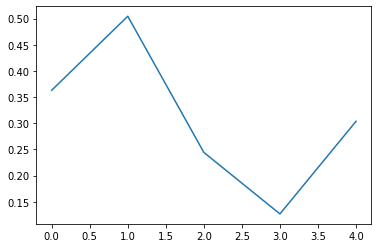

In [37]:
x_new=train_dict[8][20].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_1.online_train(x_new,label_new)

In [38]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

tensor(0.6837, grad_fn=<NegBackward>)
tensor(0.9910, grad_fn=<NegBackward>)
tensor(1.1378, grad_fn=<NegBackward>)
tensor(0.4876, grad_fn=<NegBackward>)
tensor(0.5234, grad_fn=<NegBackward>)
tensor(0.3871, grad_fn=<NegBackward>)
tensor(0.3960, grad_fn=<NegBackward>)
tensor(1.1864, grad_fn=<NegBackward>)
tensor(0.5953, grad_fn=<NegBackward>)


8


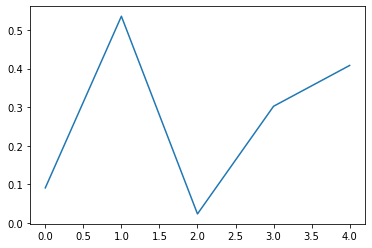

In [45]:
x_new=train_dict[8][21].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_1.online_train(x_new,label_new)

In [46]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

tensor(0.5913, grad_fn=<NegBackward>)
tensor(0.8755, grad_fn=<NegBackward>)
tensor(0.9283, grad_fn=<NegBackward>)
tensor(1.3907, grad_fn=<NegBackward>)
tensor(1.0358, grad_fn=<NegBackward>)
tensor(0.2722, grad_fn=<NegBackward>)
tensor(0.4920, grad_fn=<NegBackward>)
tensor(1.2649, grad_fn=<NegBackward>)
tensor(0.5070, grad_fn=<NegBackward>)


In [ ]:
for i in range(0,30):
    print(i)
    print(active_bnn.predictive_distribution_entropy(train_dict[1][i]))
    print(active_bnn.predictive_distribution_entropy(train_dict[8][i]))

In [ ]:
for i in range(0,30):
    x_new=train_dict[8][i].view(-1,1,28,28)
    label_new=torch.tensor([8])

    active_bnn.online_train(x_new,label_new)

In [ ]:
for i in range(0,30):
    print(i)
    print(active_bnn.predictive_distribution_entropy(train_dict[1][i]))
    print(active_bnn.predictive_distribution_entropy(train_dict[8][i]))